In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Model Build

## Activation Fucntions

In [2]:
def activation_function(layer, func):
    activation_functions = {
        "relu": F.relu,
        "relu6": F.relu6,
        "leaky_relu": F.leaky_relu,
        "sigmoid": torch.sigmoid,
        "tanh": torch.tanh,
        "gelu": F.gelu,
    }

    if func not in activation_functions:
        raise ValueError(f"Unknown activation function: {func}")

    return activation_functions[func](layer)

## Network 

In [3]:
def network(input_size, output_size, hidden_units):
    
    layers = nn.ModuleDict()
    layers["input"] = nn.Linear(input_size, output_size)

    if hidden_units is not None:
        layers["input"] = nn.Linear(input_size, hidden_units[0])
        for i in range(len(hidden_units) - 1):
            layers[f"hidden{i+1}"] = nn.Linear(hidden_units[i], hidden_units[i + 1])

        layers[f"hidden{len(hidden_units)}"] = nn.Linear(
            hidden_units[-1], hidden_units[-1]
        )
        layers["output"] = nn.Linear(hidden_units[-1], output_size)
    else:
        layers["output"] = nn.Linear(output_size, output_size)

    return layers

## Model Class

In [4]:
def create_model(args):

    input_size = args["input_size"]
    output_size = args["output_size"]
    hidden_units = args["hidden_units"]
    drop_out = args["drop_out"]
    batch_normalization = args["batch_normalization"]
    activation = args["activation"]

    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.layers = network(input_size, output_size, hidden_units)
            self.drop_out = drop_out
            self.batch_normalization = batch_normalization
            self.activation = activation

            # Get hidden layers
            self.hidden_layers = [
                self.layers[layer] for layer in self.layers.keys() if "hidden" in layer
            ]

            # Define Dropout layers for hiidden layers and add to the model dict
            if drop_out is not None:
                for i, layer in enumerate(self.hidden_layers):
                    drop_out_layer = nn.Dropout(drop_out)
                    self.layers["dropout_{}".format(i)] = drop_out_layer

            # Define Batch Normalization layers for hiidden layers and add to the model dict
            if batch_normalization:
                for i, layer in enumerate(self.hidden_layers):
                    num_features = layer.out_features
                    batch_norm_layer = nn.BatchNorm1d(num_features)
                    self.layers["batch_norm_{}".format(i)] = batch_norm_layer

        def forward(self, x):
            x = self.layers["input"](x)
            x = activation_function(x, self.activation)

            for i, layer in enumerate(self.hidden_layers):
                x = layer(x)

                # Apply Batch norm before activation
                if self.batch_normalization:
                    batch_norm_layer = self.layers["batch_norm_{}".format(i)]
                    if self.training:
                        x = batch_norm_layer(x)

                x = activation_function(x, self.activation)

                # Apply Dropout after the activation
                if self.drop_out:
                    drop_out_layer = self.layers["dropout_{}".format(i)]
                    if self.training:
                        x = drop_out_layer(x)

            x = self.layers["output"](x)

            return x

    return Model()

# Traning Parameters

## Optimizers

In [5]:
def optimizer(optimizer_name, model_parameters, learning_rate):
    # Get model parameters from model.
    parameters = list(model_parameters)

    optimizers = {
        "SGD": torch.optim.SGD(parameters, lr=learning_rate, momentum=0.9, weight_decay=0.001),
        "Adam": torch.optim.Adam(parameters, lr=learning_rate, weight_decay=0.001),
        "Adagrad": torch.optim.Adagrad(parameters, lr=learning_rate),
        "RMSprop": torch.optim.RMSprop(parameters, lr=learning_rate),
        "AdamW": torch.optim.AdamW(parameters, lr=learning_rate, weight_decay=0.001),
        "Adamax": torch.optim.Adamax(parameters, lr=learning_rate, weight_decay=0.001),
    }

    if optimizer_name not in optimizers:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    return optimizers[optimizer_name]

## Weight Initializations

In [6]:
def initialize_weights(model, initialization_method, nonlinearity=None):
    initializers = {
        "uniform": init.uniform_,
        "normal": init.normal_,
        "xavier_uniform": init.xavier_uniform_,
        "xavier_normal": init.xavier_normal_,
        "kaiming_uniform": init.kaiming_uniform_,
        "kaiming_normal": init.kaiming_normal_,
    }

    nonlinearity_gain = {
        "relu": init.calculate_gain("relu"),
        "leaky_relu": init.calculate_gain("leaky_relu"),
        "tanh": init.calculate_gain("tanh"),
        "sigmoid": init.calculate_gain("sigmoid"),
        "selu": init.calculate_gain("selu"),
    }

    if initialization_method not in initializers:
        raise ValueError(f"Unknown initialization method: {initialization_method}")

    if nonlinearity is not None:
        if nonlinearity not in nonlinearity_gain:
            raise ValueError(f"Unknown nonlinearity: {nonlinearity}")
        gain = nonlinearity_gain[nonlinearity]
    else:
        gain = 1.0  # Default gain is 1.0 if no nonlinearity is specified

    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            if "xavier" in initialization_method:
                initializers[initialization_method](module.weight, gain=gain)
            elif "kaiming" in initialization_method:
                initializers[initialization_method](module.weight, a=gain)
            else:
                initializers[initialization_method](module.weight)
            if module.bias is not None:
                init.constant_(module.bias, 0)  # Initialize bias to zeros

## Loss Functions

In [7]:
def loss_function(loss_name):
    loss_functions = {
        "MSE": nn.MSELoss(),
        "CE": nn.CrossEntropyLoss(),
        "BCEWithLogits": nn.BCEWithLogitsLoss(),
        "L1": nn.L1Loss(),
    }

    if loss_name not in loss_functions:
        raise ValueError(f"Unknown loss function: {loss_name}")

    loss_fn = loss_functions[loss_name]
    return loss_fn

# Train Model

## Use GPU

In [8]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print(device)

1
cuda:0


## Traning Model For Categorical Classifications

In [9]:
def model_train_categorical(args):

    model = args["model"]
    train_loader = args["train_loader"]
    test_loader = args["test_loader"]
    numepochs = args["numepochs"]
    initialization_method = args["initialization_method"]
    nonlinearity = args["nonlinearity"]
    optimizer_type = args["optimizer_type"]
    learning_rate = args["learning_rate"]
    lossfunc = args["lossfunc"]
    scheduler_settings = args["scheduler_settings"]

    # Switch model to the training mode
    model.train()
    initialize_weights(model, initialization_method, nonlinearity)
    
    # define optimizer instance
    optimizer_instance = optimizer(optimizer_type, model.parameters(), learning_rate)
    
    # define patience based scheduler.
    if scheduler_settings is not None:
        scheduler = ReduceLROnPlateau(
            optimizer_instance,
            mode=scheduler_settings[0],
            patience=scheduler_settings[1],
            cooldown=scheduler_settings[2],
            factor=scheduler_settings[3],
        )
    # Define loss func    
    lossfun = loss_function(lossfunc)

    # Send the model to the GPU
    model.to(device)

    # Define Lists for loss and acc
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    
    for epochi in range(numepochs):

        # define batch based acc and loss lists
        test_batchAcc = []
        test_batchLoss = []
        batchLoss = []
        batchAcc = []

        # iterate over train batch
        for x, y in train_loader:
            # send the batch to the GPU
            x = x.to(device)
            y = y.to(device)
            
            # forward pass and calculate the loss
            yHat = model(x)
            loss = lossfun(yHat, y)

            # Log lr
            previous_lr = optimizer_instance.param_groups[0]["lr"]
            
            # backpropagiton
            # Calculate the loss and update the optimizer
            optimizer_instance.zero_grad()
            loss.backward()
            optimizer_instance.step()

            # add loss to the list
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            # Because of BCEWithLogis is defaulty apply sigmoid to the output
            # compare the output and if the output is greater than zero and equaliness to the acc
            # get the mean and scale with percantage than add to the batch acc
            batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

        # when the val loss stop decresing update the lr
        if scheduler_settings is not None:
            val_loss = np.mean(test_batchLoss)
            scheduler.step(val_loss)
            current_lr = optimizer_instance.param_groups[0]["lr"]
            if previous_lr != current_lr:
                print(f"Learning rate at epoch {epochi:2d} : {current_lr:.2e}")

        # add batch acc avg to the train acc list
        trainAcc[epochi] = np.mean(batchAcc)

        # add batch loss avg to the train loss list
        trainLoss[epochi] = np.mean(batchLoss)

        # Switch the eval mode
        model.eval()
        
        # iterate over test loader
        for x, y in test_loader:
            # send GPU
            x = x.to(device)
            y = y.to(device)

            # deactive the grad
            with torch.no_grad():  
                yHat = model(x)
            test_batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
            test_batchLoss.append(lossfun(yHat, y).item())

        # add test acc and batch loss avg to the corrosponding list
        testAcc[epochi] = np.mean(test_batchAcc)
        testLoss[epochi] = np.mean(test_batchLoss)
    
    # return test and train, loss and accuaries
    return trainAcc, testAcc, testLoss, trainLoss

## Traning Model For Numerical Values

In [10]:
def model_train_numerical(args):

    model = args["model"]
    train_loader = args["train_loader"]
    test_loader = args["test_loader"]
    numepochs = args["numepochs"]
    initialization_method = args["initialization_method"]
    nonlinearity = args["nonlinearity"]
    optimizer_type = args["optimizer_type"]
    learning_rate = args["learning_rate"]
    lossfunc = args["lossfunc"]
    scheduler_settings = args["scheduler_settings"]

    # Switch model to the training mode
    model.train()
    initialize_weights(model, initialization_method, nonlinearity)

    # define optimizer instance
    optimizer_instance = optimizer(optimizer_type, model.parameters(), learning_rate)
    
    # define patience based scheduler.
    if scheduler_settings is not None:
        scheduler = ReduceLROnPlateau(
            optimizer_instance,
            mode=scheduler_settings[0],
            patience=scheduler_settings[1],
            cooldown=scheduler_settings[2],
            factor=scheduler_settings[3],
        )
    # Define loss func 
    lossfun = loss_function(lossfunc)
    
    # Send the model to the GPU
    model.to(device)

    # Define Lists for loss and err
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainError = torch.zeros(numepochs)
    testError = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # loop over training data batches
        test_batchLoss = []
        test_batchError = []
        batchLoss = []
        batchError = []
        # iterate over train batch
        for x, y in train_loader:
            
            # send the batch to the GPU
            x = x.to(device)
            y = y.to(device)
            
            # forward pass and loss
            yHat = model(x)
            loss = lossfun(yHat, y)

            # Log Lr
            previous_lr = optimizer_instance.param_groups[0]["lr"]
            
            # backpropagiton
            # Calculate the loss and update the optimizer
            optimizer_instance.zero_grad()
            loss.backward()
            optimizer_instance.step()

            # add loss to the list
            batchLoss.append(loss.item())

            # compute training percentage error for this batch with MAE
            batchError.append(torch.mean(torch.abs((yHat - y) / y)).item() * 100)

        # when the val loss stop decresing update the lr
        if scheduler_settings is not None:
            val_loss = np.mean(test_batchLoss)
            scheduler.step(val_loss)
            current_lr = optimizer_instance.param_groups[0]["lr"]
            if previous_lr != current_lr:
                print(f"Learning rate at epoch {epochi:2d} : {current_lr:.2e}")

        # get average loss and percentage error across the batches
        trainLoss[epochi] = np.mean(batchLoss)
        trainError[epochi] = np.mean(batchError)

        # Switch model to the eval mode
        model.eval()
        for x, y in test_loader:
            
            # Send GPU
            x = x.to(device)
            y = y.to(device)
            
            # deactive the grad
            with torch.no_grad():
                yHat = model(x)
            test_batchLoss.append(lossfun(yHat, y).item())
            test_batchError.append(torch.mean(torch.abs((yHat - y) / y)).item() * 100)

        # test loss and percentage error for this epoch
        testLoss[epochi] = np.mean(test_batchLoss)
        testError[epochi] = np.mean(test_batchError)

    return trainLoss, testLoss, trainError, testError

# Test Model

## Test Multiple Categorical Models

In [11]:
def test_multiple_model_categorical(model_setting, train_setting):
    
    # Based on the spesifications create model and train it
    model = create_model(model_setting)
    train_setting["model"] = model

    trainAcc, testAcc, testLoss, trainLoss = model_train_categorical(train_setting)

    # Get All Parameters to a dict
    model_design = {}
    model_design["model name"] = model_setting["model name"]

    for arg_name, arg_value in train_setting.items():
        if arg_name == "train_loader" or arg_name == "test_loader":
            num_batches = len(arg_value)
            batch_size = arg_value.batch_size
            total_samples = num_batches * batch_size
            model_design[arg_name] = {
                "Number of batches": num_batches,
                "Batch size": batch_size,
                "Total samples": total_samples,
            }
        else:
            model_design[arg_name] = arg_value

    result = {
        "model name": model_setting["model name"],
        "train method": train_setting["train method"],
        "train_acc": trainAcc,
        "test_acc": testAcc,
        "train_loss": trainLoss,
        "test_loss": testLoss,
        "Final model train performance": trainAcc[-1],
        "Final model test performance": testAcc[-1],
        "model parameters": model_design,
    }

    return result, model

## Test Multiple Numerical Models

In [12]:
def test_multiple_model_numerical(model_setting, train_setting):
    # Based on the spesifications create model and train it
    model = create_model(model_setting)
    train_setting["model"] = model

    trainLoss, testLoss, trainError, testError = model_train_numerical(train_setting)

    # Get All Parameters to a dict
    model_design = {}
    model_design["model name"] = model_setting["model name"]

    for arg_name, arg_value in train_setting.items():
        if arg_name == "train_loader" or arg_name == "test_loader":
            num_batches = len(arg_value)
            batch_size = arg_value.batch_size
            total_samples = num_batches * batch_size
            model_design[arg_name] = {
                "Number of batches": num_batches,
                "Batch size": batch_size,
                "Total samples": total_samples,
            }
        else:
            model_design[arg_name] = arg_value

    result = {
        "model name": model_setting["model name"],
        "train method": train_setting["train method"],
        "train_error": trainError,
        "test_error": testError,
        "train_loss": trainLoss,
        "test_loss": testLoss,
        "Final model train performance": trainError[-1],
        "Final model test performance": testError[-1],
        "model parameters": model_design,
    }

    return result, model

# Plot Model Performance

## Plot Categorical Model Performance

In [13]:
def plot_model_test_categorical(model_test_results):

    max_train_acc, train_model_indx = max(
        (model["Final model train performance"], i)
        for i, model in enumerate(model_test_results)
    )
    max_test_acc, test_model_indx = max(
        (model["Final model test performance"], i)
        for i, model in enumerate(model_test_results)
    )

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    # Plot train losses
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[0, 0].plot(
            result["train_loss"], label=model_name, linestyle="-", marker="s"
        )

    axs[0, 0].set_title("Train Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # Plot test losses
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[0, 1].plot(result["test_loss"], label=model_name, linestyle="-", marker="o")

    axs[0, 1].set_title("Test Loss")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()

    # Plot train accuracies
    best_train_acc_idx = np.argmax(
        [max(result["train_acc"]) for result in model_test_results]
    )
    best_train_acc_result = model_test_results[best_train_acc_idx]
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[1, 0].plot(
            result["train_acc"],
            label=f"{model_name} - {result['train_acc'][-1]:.2f}",
            linestyle="-",
            marker="s",
        )

    axs[1, 0].set_title(
        f"Train Accuracy - Best: {max_train_acc:.2f} (Model {train_model_indx+1})"
    )
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].legend()

    # Plot test accuracies
    best_test_acc_idx = np.argmax(
        [max(result["test_acc"]) for result in model_test_results]
    )
    best_test_acc_result = model_test_results[best_test_acc_idx]
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[1, 1].plot(
            result["test_acc"],
            label=f"{model_name} - {result['test_acc'][-1]:.2f}",
            linestyle="-",
            marker="o",
        )

    axs[1, 1].set_title(
        f"Test Accuracy - Best: {max_test_acc:.2f} (Model {test_model_indx+1})"
    )
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Accuracy")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
    print(model_test_results[test_model_indx]["model parameters"])

## Plot Numerical Model Performance

In [14]:
def plot_model_test_numerical(model_test_results):

    min_train_error, train_model_indx = min(
        (model["Final model train performance"], i)
        for i, model in enumerate(model_test_results)
    )
    min_test_error, test_model_indx = min(
        (model["Final model test performance"], i)
        for i, model in enumerate(model_test_results)
    )

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))

    # Plot train losses
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[0, 0].plot(
            result["train_loss"], label=model_name, linestyle="-", marker="s"
        )

    axs[0, 0].set_title("Train Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # Plot test losses
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[0, 1].plot(result["test_loss"], label=model_name, linestyle="-", marker="o")

    axs[0, 1].set_title("Test Loss")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].legend()

    # Plot train errors (Mean Absolute Error)
    best_train_error_idx = np.argmin(
        [min(result["train_error"]) for result in model_test_results]
    )
    best_train_error_result = model_test_results[best_train_error_idx]
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[1, 0].plot(
            result["train_error"],
            label=f"{model_name} - {result['train_error'][-1]:.2f}",
            linestyle="-",
            marker="s",
        )

    axs[1, 0].set_title(
        f"Train MAE - Min Err: {min_train_error:.2f} (Model {train_model_indx+1})"
    )
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Mean Absolute Error")
    axs[1, 0].legend()

    # Plot test errors (Mean Absolute Error)
    best_test_error_idx = np.argmin(
        [min(result["test_error"]) for result in model_test_results]
    )
    best_test_error_result = model_test_results[best_test_error_idx]
    for i, result in enumerate(model_test_results):
        model_name = result["model name"] + " - " + result["train method"]
        axs[1, 1].plot(
            result["test_error"],
            label=f"{model_name} - {result['test_error'][-1]:.2f}",
            linestyle="-",
            marker="o",
        )

    axs[1, 1].set_title(
        f"Test MAE - Min Err: {min_test_error:.2f} (Model {test_model_indx+1})"
    )
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Mean Absolute Error")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()
    print(model_test_results[test_model_indx]["model parameters"])

# Splitting Data

In [15]:
# Split Data and conver to the Data Loader
def data_split(x, y, test_size, batch_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    x_train = TensorDataset(x_train, y_train)
    train_loader = DataLoader(x_train, batch_size=batch_size, shuffle=True, drop_last=True)

    x_test = TensorDataset(x_test, y_test)
    test_loader = DataLoader(x_test, batch_size=batch_size)
    
    return train_loader, test_loader

# Data Preprocessing 

## Data Load and Copy

In [16]:
# Load Data and get copy
train_df = pd.read_csv("train_data.csv")

original_train_dataset = train_df.copy()

dataset = train_df.copy()

print("Train data size : ", dataset.shape)

Train data size :  (4020, 13)


In [17]:
dataset.head(n=1)

,CustomerID,Surname,NetworkScore,Region,Gender,Age,Tenure,MonthlyCharge,NumOfProducts,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited
0,4971,Moreno,25.0,South,Female,26.0,11,134.2,1,0,1.0,NaN,1


## Data Info and Types

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CustomerID             4020 non-null   int64  
 1   Surname                4020 non-null   object 
 2   NetworkScore           3821 non-null   float64
 3   Region                 4020 non-null   object 
 4   Gender                 4020 non-null   object 
 5   Age                    3812 non-null   float64
 6   Tenure                 4020 non-null   int64  
 7   MonthlyCharge          4020 non-null   float64
 8   NumOfProducts          4020 non-null   int64  
 9   HasInternetService     4020 non-null   int64  
 10  IsActiveMember         3822 non-null   float64
 11  EstimatedMonthlyUsage  3823 non-null   float64
 12  Exited                 4020 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 408.4+ KB


## Data Drop Columns

In [19]:
# Drop Id and Names
dataset = dataset.drop(["CustomerID", "Surname"], axis=1)

## Separate Features

In [20]:
# Split Features to the corresponding type
numerical_columns = [
    "NetworkScore",
    "Age",
    "Tenure",
    "MonthlyCharge",
    "EstimatedMonthlyUsage",
]
one_hot_columns = ["Region", "Gender", "NumOfProducts"]
label_columns = ["HasInternetService", "IsActiveMember", "Exited"]

# Check Numerical Columns distribution
dataset[numerical_columns].describe()

,NetworkScore,Age,Tenure,MonthlyCharge,EstimatedMonthlyUsage
count,3821.000000,3812.000000,4020.000000,4020.000000,3823.000000
mean,51.172468,43.961962,10.092786,109.808458,548.373380
std,28.975876,15.300416,6.076202,52.417745,258.494824
min,1.000000,18.000000,0.000000,20.030000,100.090000
25%,26.000000,31.000000,5.000000,64.652500,329.485000
50%,52.000000,44.000000,10.000000,109.335000,546.250000
75%,77.000000,57.000000,15.000000,155.782500,772.725000
max,100.000000,70.000000,20.000000,199.960000,999.820000


## Data Categorical Columns Conversion

In [21]:
gender_map = {"Male": 1, "Female": 2, "Other": 3}
region_map = {"South": 1, "North": 2, "East": 3, "West": 4}

# Convert string feauters to the numbers
dataset["Gender"] = dataset["Gender"].map(gender_map)
dataset["Region"] = dataset["Region"].map(region_map)

## Data One Hot Columns Encoding

In [22]:
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to categorical columns
encoded_columns = encoder.fit_transform(dataset[one_hot_columns])

# Store one hot encoded features to a df
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(one_hot_columns))

# Drop the original columns and concatenate the encoded columns
dataset.drop(one_hot_columns, axis=1, inplace=True)
df = pd.concat([dataset, encoded_df], axis=1)

# Update the dataset
dataset = df.copy()

In [23]:
dataset.head(n=1)

,NetworkScore,Age,Tenure,MonthlyCharge,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited,Region_1,Region_2,Region_3,Region_4,Gender_1,Gender_2,Gender_3,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,25.0,26.0,11,134.2,0,1.0,NaN,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


## Data Type Conversion

In [24]:
 # Convert Feauters to the float
def convert_to_float(df):

    for column in df.columns:
        try:
            df[column] = df[column].astype(float)
        except ValueError:
            print(f"Unable to convert column '{column}' to float.")
    return df


dataset = convert_to_float(dataset)

# check feauters types
print(dataset.dtypes)

NetworkScore             float64
Age                      float64
Tenure                   float64
MonthlyCharge            float64
HasInternetService       float64
IsActiveMember           float64
EstimatedMonthlyUsage    float64
Exited                   float64
Region_1                 float64
Region_2                 float64
Region_3                 float64
Region_4                 float64
Gender_1                 float64
Gender_2                 float64
Gender_3                 float64
NumOfProducts_1          float64
NumOfProducts_2          float64
NumOfProducts_3          float64
NumOfProducts_4          float64
dtype: object


## Data NaN Value Check

In [25]:
# Check NaN values
nan_sum = dataset.isna().sum()
print(nan_sum[nan_sum > 0])

NetworkScore             199
Age                      208
IsActiveMember           198
EstimatedMonthlyUsage    197
dtype: int64


# Predict NaN Values

## Predict Network Score

### Prepare Dataset For Network Score Prediction

In [26]:
train_df_network_score = dataset.copy()

# Drop Nan columns
train_df_network_score = train_df_network_score.drop(["IsActiveMember", "EstimatedMonthlyUsage", "Age"], axis=1)

# Apply logarithmic scaling to the target variable
train_df_network_score["NetworkScore"] = np.log1p(train_df_network_score["NetworkScore"])

# Filter rows without NaN values
train_df_network_score_not_nan = train_df_network_score.dropna(subset=['NetworkScore'])

# Extract input features and target variable for rows without NaN
train_df_x = train_df_network_score_not_nan.drop("NetworkScore", axis=1)
train_df_y = train_df_network_score_not_nan["NetworkScore"]

# Remove specified columns from numerical_columns list using list comprehension
network_score_numerical_columns = [col for col in numerical_columns if col not in ['NetworkScore', 'Age', 'EstimatedMonthlyUsage']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
train_df_x[network_score_numerical_columns] = scaler.fit_transform(train_df_x[network_score_numerical_columns])


# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_df_x.values).float()
train_y = torch.tensor(train_df_y.values).float().unsqueeze(1)
train_x.shape

torch.Size([3821, 15])

### Model Train For Predicting Network Scores

In [27]:
train_loader, test_loader = data_split(train_x, train_y, 0.2, 64)

model = {
    "model name": "3-nh-relu",
    "input_size": 15,
    "output_size": 1,
    "hidden_units": [64, 32, 64],
    "drop_out": 0.5,
    "batch_normalization": True,
    "activation": "relu",
}


train_model = {
    "train method": "k.u-e.100-Adam-lr.0001-MSE",
    "model": None,
    "train_loader": train_loader,
    "test_loader": test_loader,
    "numepochs": 100,
    "initialization_method": "kaiming_uniform",
    "nonlinearity": 'relu',
    "optimizer_type": "Adam",
    "learning_rate": 0.001,
    "scheduler_settings": ["min", 10, 5, 0.1],
    "lossfunc": "MSE",
}

model_predict_network_score_train_df = []

test_model_1, model_train_df_network_score = test_multiple_model_numerical(model, train_model)
model_predict_network_score_train_df.append(test_model_1)

Learning rate at epoch 10 : 1.00e-04
Learning rate at epoch 26 : 1.00e-05
Learning rate at epoch 42 : 1.00e-06
Learning rate at epoch 58 : 1.00e-07
Learning rate at epoch 74 : 1.00e-08


### Visualize Model Performance of Network Score Predictor

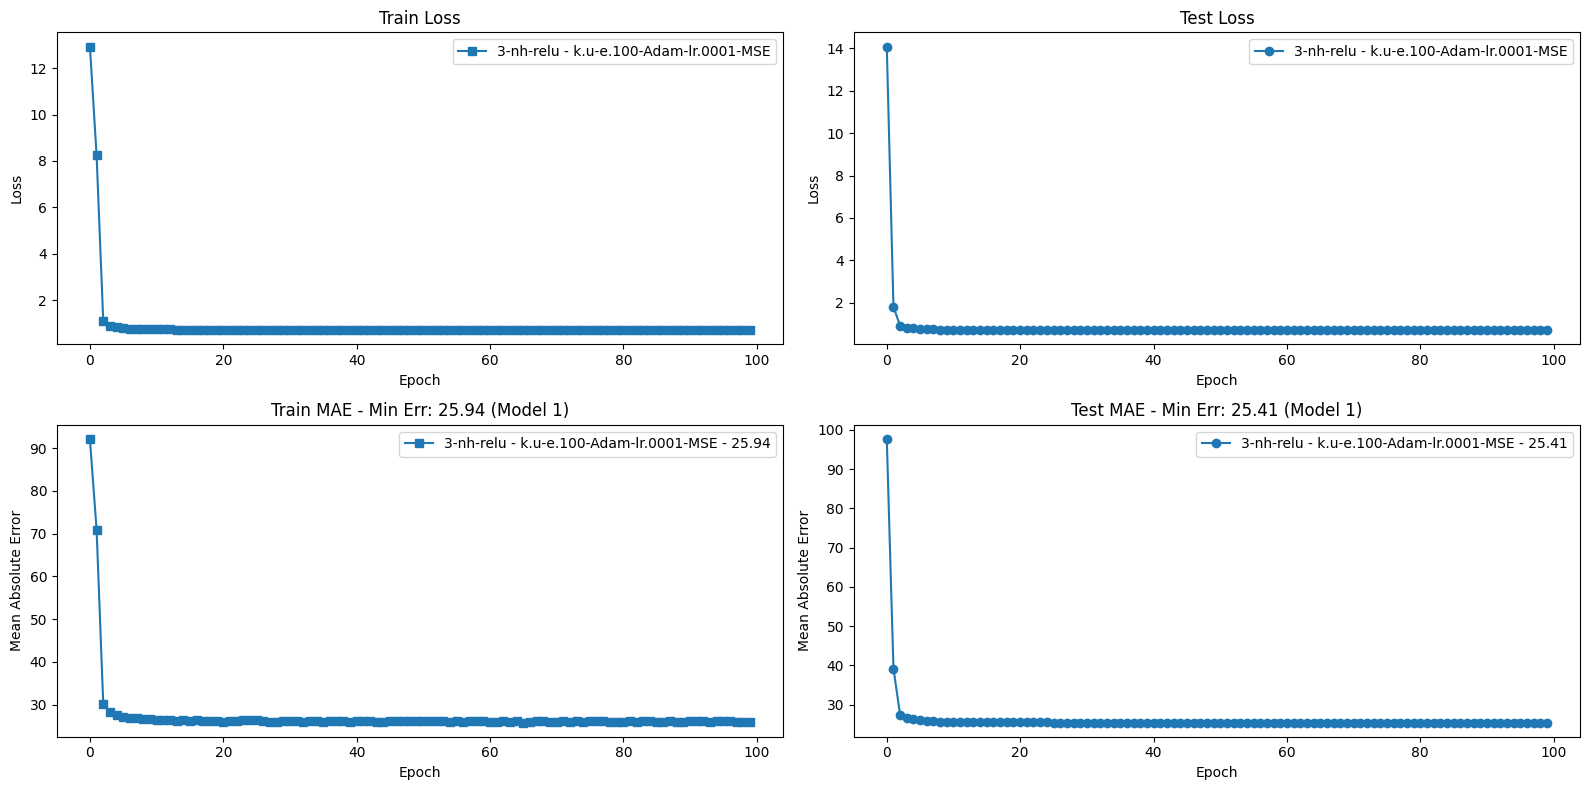

{'model name': '3-nh-relu', 'train method': 'k.u-e.100-Adam-lr.0001-MSE', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=15, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace=False)
    (batch_norm_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), 'train_loader': {'Number of batches': 47, 'Batch size': 64, 'Total samples': 3008}, 'test_loader': {'Number of b

In [28]:
plot_model_test_numerical(model_predict_network_score_train_df)

### Update Original Dataset NaN Values With Predicted Results

In [29]:
# Filter rows with NaN values in 'NetworkScore'
train_df_nan_mask = train_df_network_score["NetworkScore"].isna()
train_df_network_score_nan = train_df_network_score[train_df_nan_mask]


# Extract input features and target variable for rows with NaN
train_x = train_df_network_score_nan.drop("NetworkScore", axis=1)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_x[network_score_numerical_columns] = scaler.fit_transform(train_x[network_score_numerical_columns])


# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_x.values).float().to(device)


# Predict Train Df NaN values
model_train_df_network_score.eval()
with torch.no_grad():
    train_df_predictions = model_train_df_network_score(train_x).squeeze()

# Convert predictions back to numpy array
train_df_predictions_np = train_df_predictions.cpu().numpy()

# Inverse the logarithmic transformation
train_df_predictions_original_scale = np.expm1(train_df_predictions_np)

# Replace NaN values with predictions in the original df
dataset.loc[train_df_nan_mask, "NetworkScore"] = train_df_predictions_original_scale

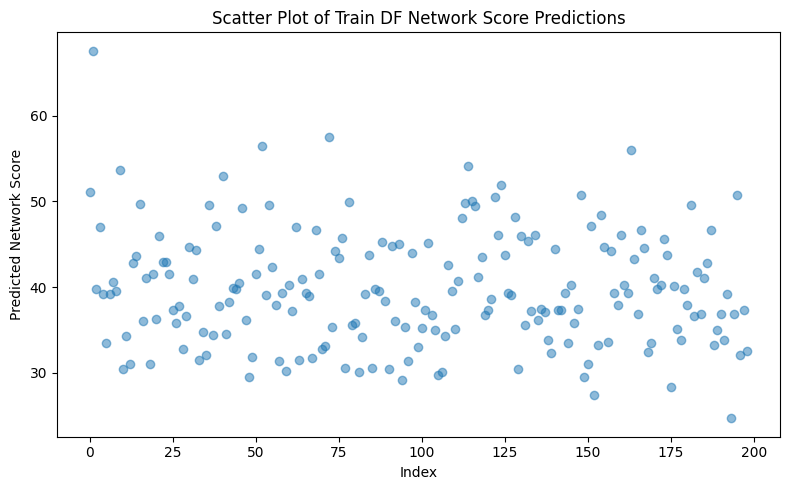

In [30]:
# Scatter Plot Function
def create_scatter_plot(ax, predictions, title):
    ax.scatter(range(len(predictions)), predictions, alpha=0.5)
    ax.set_xlabel("Index")
    ax.set_ylabel("Predicted Network Score")
    ax.set_title(title)


# Plotting
fig, ax = plt.subplots(figsize=(8, 5))  # Single plot

# Plot for train set
create_scatter_plot(ax,train_df_predictions_original_scale,"Scatter Plot of Train DF Network Score Predictions",)

plt.tight_layout()
plt.show()

## Predict Age

### Prepare Dataset For Age Prediction

In [31]:
train_df_age = dataset.copy()

# Drop specified columns
train_df_age = train_df_age.drop([ "IsActiveMember", "EstimatedMonthlyUsage"], axis=1)

# Apply logarithmic scaling to the target variable
train_df_age["Age"] = np.log1p(train_df_age["Age"])


# Filter rows without NaN values in 'Age'
train_df_age_not_nan = train_df_age.dropna(subset=['Age'])



# Extract input features and target variable for rows without NaN
train_df_x = train_df_age_not_nan.drop("Age", axis=1)
train_df_y = train_df_age_not_nan["Age"]

# Remove specified columns from numerical_columns list using list comprehension
age_numerical_columns = [col for col in numerical_columns if col not in ['Age', 'EstimatedMonthlyUsage']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_df_x[age_numerical_columns] = scaler.fit_transform(train_df_x[age_numerical_columns])



# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_df_x.values).float()
train_y = torch.tensor(train_df_y.values).float().unsqueeze(1)

train_x.shape

torch.Size([3812, 16])

### Model Train For Predicting Age

In [32]:
train_loader, test_loader = data_split(train_x, train_y, 0.2, 64)

model = {
    "model name": "3-nh-relu",
    "input_size": 16,
    "output_size": 1,
    "hidden_units": [64, 32, 64],
    "drop_out": 0.5,
    "batch_normalization": True,
    "activation": "relu",
}


train_model = {
    "train method": "k.u-e.100-Adam-lr.0001-MSE",
    "model": None,
    "train_loader": train_loader,
    "test_loader": test_loader,
    "numepochs": 100,
    "initialization_method": "kaiming_uniform",
    "nonlinearity": 'relu',
    "optimizer_type": "Adam",
    "learning_rate": 0.001,
    "scheduler_settings": ["min", 10, 5, 0.1],
    "lossfunc": "MSE",
}

model_predict_age_train_df = []

test_model_1, model_train_df_age = test_multiple_model_numerical(model, train_model)
model_predict_age_train_df.append(test_model_1)

Learning rate at epoch 10 : 1.00e-04
Learning rate at epoch 26 : 1.00e-05
Learning rate at epoch 42 : 1.00e-06
Learning rate at epoch 58 : 1.00e-07
Learning rate at epoch 74 : 1.00e-08


### Visualize Model Performance of Age Predictor

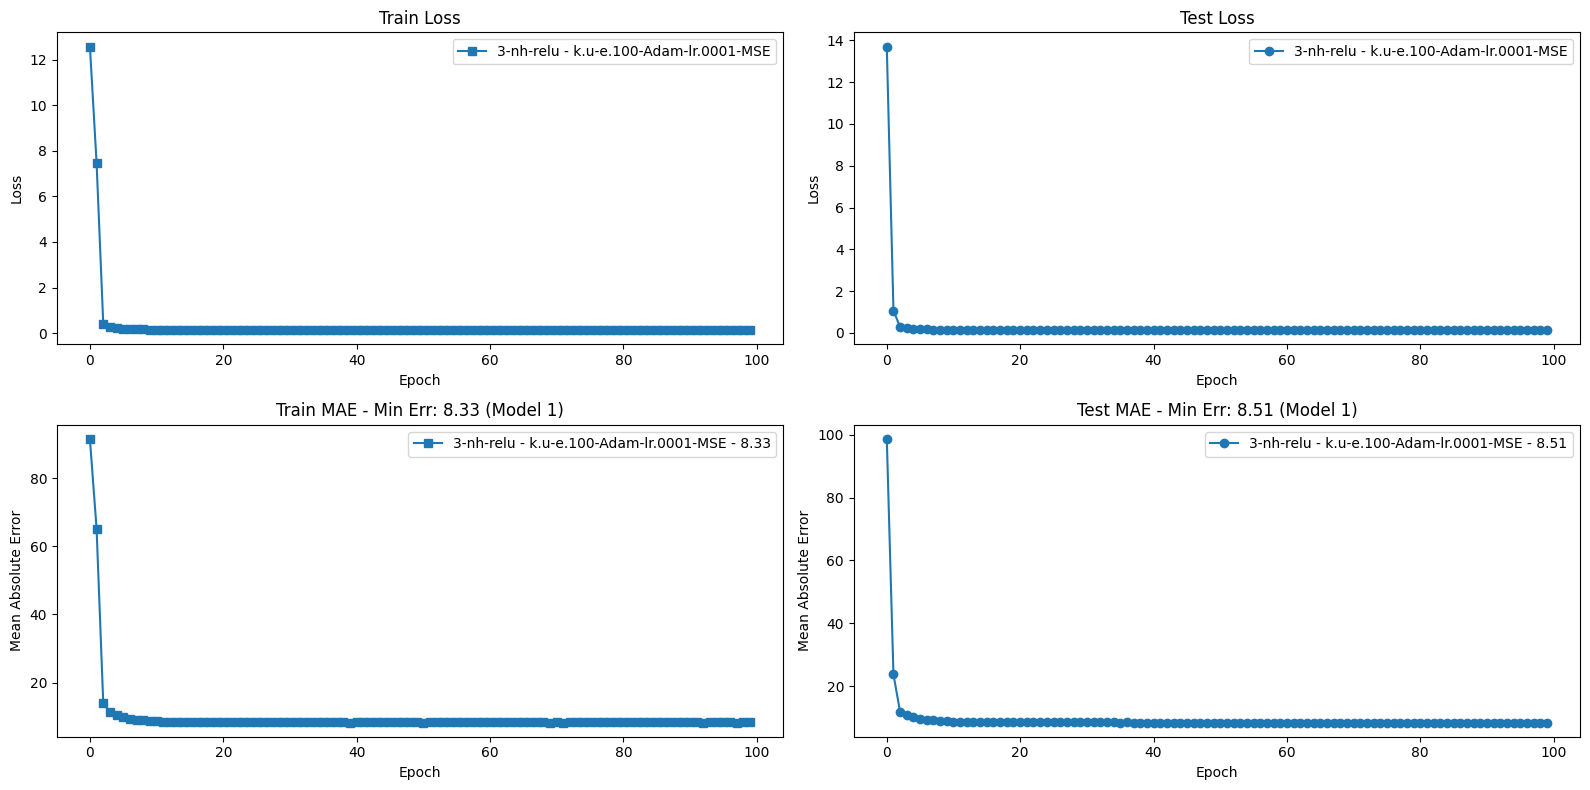

{'model name': '3-nh-relu', 'train method': 'k.u-e.100-Adam-lr.0001-MSE', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=16, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace=False)
    (batch_norm_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), 'train_loader': {'Number of batches': 47, 'Batch size': 64, 'Total samples': 3008}, 'test_loader': {'Number of b

In [33]:
plot_model_test_numerical(model_predict_age_train_df)

### Update Original Dataset NaN Values With Predicted Results

In [34]:
# Filter rows with NaN values in 'Age'
train_df_nan_mask = train_df_age["Age"].isna()
train_df_age_nan = train_df_age[train_df_nan_mask]


# Extract input features and target variable for rows with NaN
train_x = train_df_age_nan.drop("Age", axis=1)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_x[age_numerical_columns] = scaler.fit_transform(train_x[age_numerical_columns])


# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_x.values).float().to(device)


# Predict Train Df NaN values
model_train_df_age.eval()
with torch.no_grad():
    train_df_predictions = model_train_df_age(train_x).squeeze()

# Convert predictions back to numpy array
train_df_predictions_np = train_df_predictions.cpu().numpy()

# Inverse the logarithmic transformation
train_df_predictions_original_scale = np.expm1(train_df_predictions_np)

# Replace NaN values with predictions in the original df
dataset.loc[train_df_nan_mask, "Age"] = train_df_predictions_original_scale

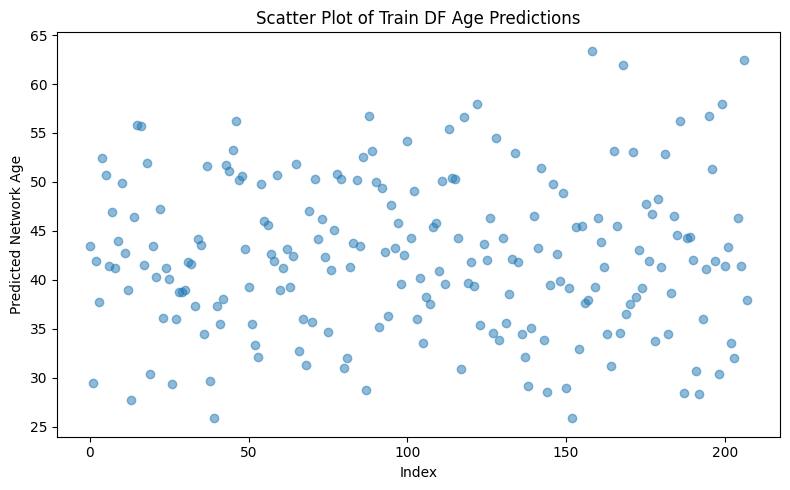

In [35]:
# Scatter Plot Function
def create_scatter_plot(ax, predictions, title):
    ax.scatter(range(len(predictions)), predictions, alpha=0.5)
    ax.set_xlabel("Index")
    ax.set_ylabel("Predicted Network Age")
    ax.set_title(title)


# Plotting
fig, ax = plt.subplots(figsize=(8, 5))  # Single plot


# Plot for train set
create_scatter_plot(ax,train_df_predictions_original_scale,"Scatter Plot of Train DF Age Predictions")

plt.tight_layout()
plt.show()

## Predict Estimated Monthly Usage

### Prepare Dataset For Estimated Monthly Usage

In [36]:
train_df_estimated_monthly_usage = dataset.copy()


# Drop specified columns
train_df_estimated_monthly_usage = train_df_estimated_monthly_usage.drop(["IsActiveMember"], axis=1)


# Apply logarithmic scaling to the target variable
train_df_estimated_monthly_usage["EstimatedMonthlyUsage"] = np.log1p(train_df_estimated_monthly_usage["EstimatedMonthlyUsage"])


# Filter rows without NaN values in 'EstimatedMonthlyUsage'
train_df_estimated_monthly_usage_not_nan = train_df_estimated_monthly_usage.dropna(subset=["EstimatedMonthlyUsage"])



# Extract input features and target variable for rows without NaN
train_df_x = train_df_estimated_monthly_usage_not_nan.drop("EstimatedMonthlyUsage", axis=1)
train_df_y = train_df_estimated_monthly_usage_not_nan["EstimatedMonthlyUsage"]

# Remove specified columns from numerical_columns list using list comprehension
estimated_monthly_usage_numerical_columns = [col for col in numerical_columns if col not in ['EstimatedMonthlyUsage']]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_df_x[estimated_monthly_usage_numerical_columns] = scaler.fit_transform(train_df_x[estimated_monthly_usage_numerical_columns])


# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_df_x.values).float()
train_y = torch.tensor(train_df_y.values).float().unsqueeze(1)
train_x.shape

torch.Size([3823, 17])

### Model Train For Predicting Estimated Monthly Usage

In [37]:
train_loader, test_loader = data_split(train_x, train_y, 0.2, 64)

model = {
    "model name": "3-nh-relu",
    "input_size": 17,
    "output_size": 1,
    "hidden_units": [64, 32, 64],
    "drop_out": 0.5,
    "batch_normalization": True,
    "activation": "relu",
}


train_model = {
    "train method": "k.u-e.100-Adam-lr.0001-MSE",
    "model": None,
    "train_loader": train_loader,
    "test_loader": test_loader,
    "numepochs": 100,
    "initialization_method": "kaiming_uniform",
    "nonlinearity": 'relu',
    "optimizer_type": "Adam",
    "learning_rate": 0.001,
    "scheduler_settings": ["min", 10, 5, 0.1],
    "lossfunc": "MSE",
}

model_predict_estimated_monthly_usage_train_df = []

test_model_1, model_train_df_estimated_monthly_usage = test_multiple_model_numerical(
    model, train_model
)
model_predict_estimated_monthly_usage_train_df.append(test_model_1)

Learning rate at epoch 10 : 1.00e-04
Learning rate at epoch 26 : 1.00e-05
Learning rate at epoch 42 : 1.00e-06
Learning rate at epoch 58 : 1.00e-07
Learning rate at epoch 74 : 1.00e-08


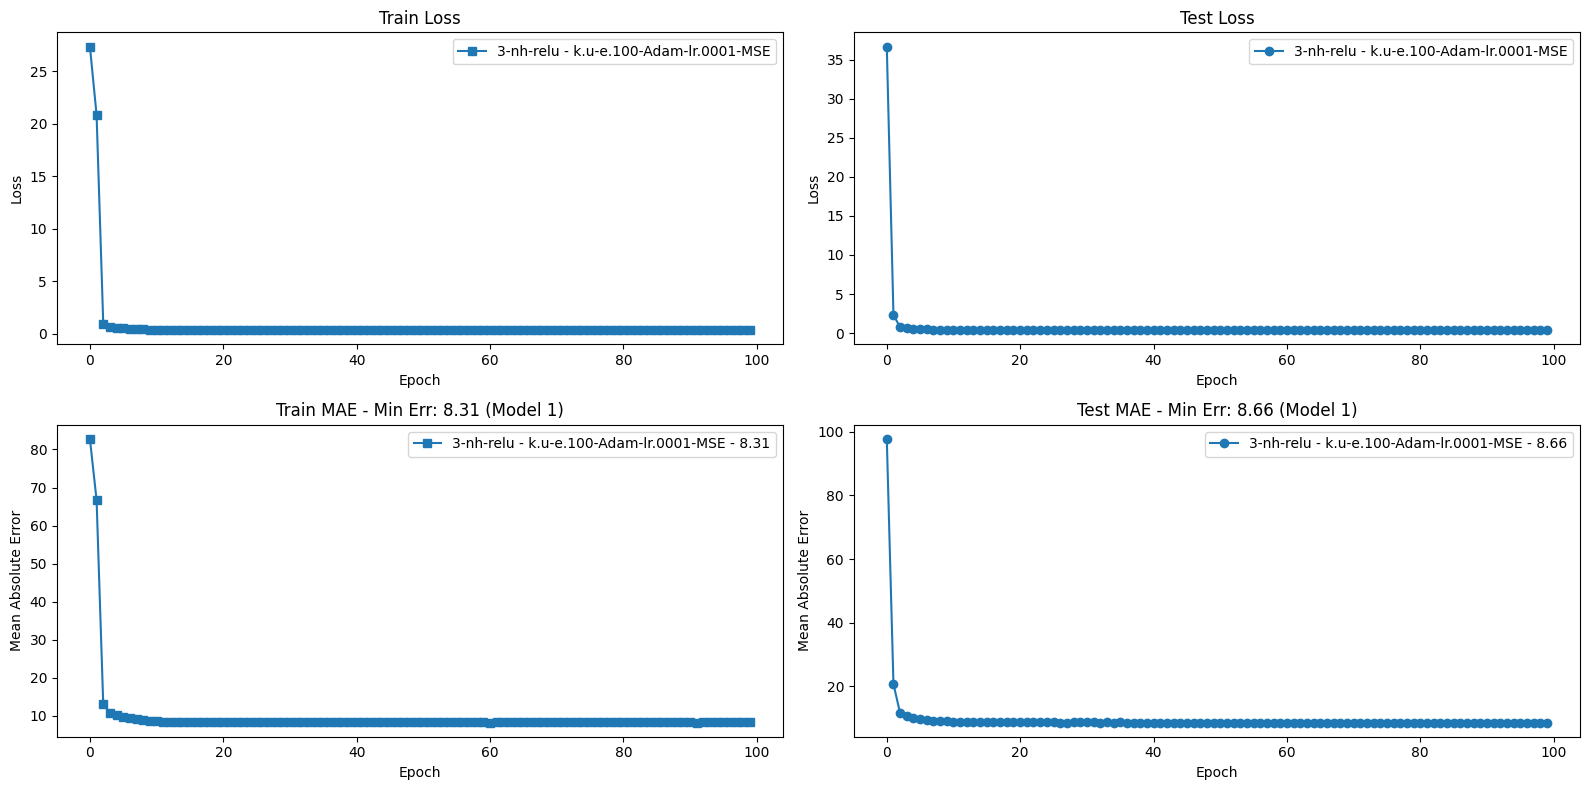

{'model name': '3-nh-relu', 'train method': 'k.u-e.100-Adam-lr.0001-MSE', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=17, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace=False)
    (batch_norm_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), 'train_loader': {'Number of batches': 47, 'Batch size': 64, 'Total samples': 3008}, 'test_loader': {'Number of b

In [38]:
plot_model_test_numerical(model_predict_estimated_monthly_usage_train_df)

### Update Original Dataset NaN Values With Predicted Results

In [39]:
# Filter rows with NaN values in 'EstimatedMonthlyUsage'
train_df_nan_mask = train_df_estimated_monthly_usage["EstimatedMonthlyUsage"].isna()
train_df_estimated_monthly_usage_nan = train_df_estimated_monthly_usage[train_df_nan_mask]


# Extract input features and target variable for rows with NaN
train_x = train_df_estimated_monthly_usage_nan.drop("EstimatedMonthlyUsage", axis=1)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_x[estimated_monthly_usage_numerical_columns] = scaler.fit_transform(train_x[estimated_monthly_usage_numerical_columns])


# Convert features and target variable to PyTorch tensors
train_x = torch.tensor(train_x.values).float().to(device)


# Predict Train Df NaN values
model_train_df_estimated_monthly_usage.eval()
with torch.no_grad():
    train_df_predictions = model_train_df_estimated_monthly_usage(train_x).squeeze()

# Convert predictions back to numpy array
train_df_predictions_np = train_df_predictions.cpu().numpy()

# Inverse the logarithmic transformation
train_df_predictions_original_scale = np.expm1(train_df_predictions_np)

# Replace NaN values with predictions in the original df
dataset.loc[train_df_nan_mask, "EstimatedMonthlyUsage"] = train_df_predictions_original_scale

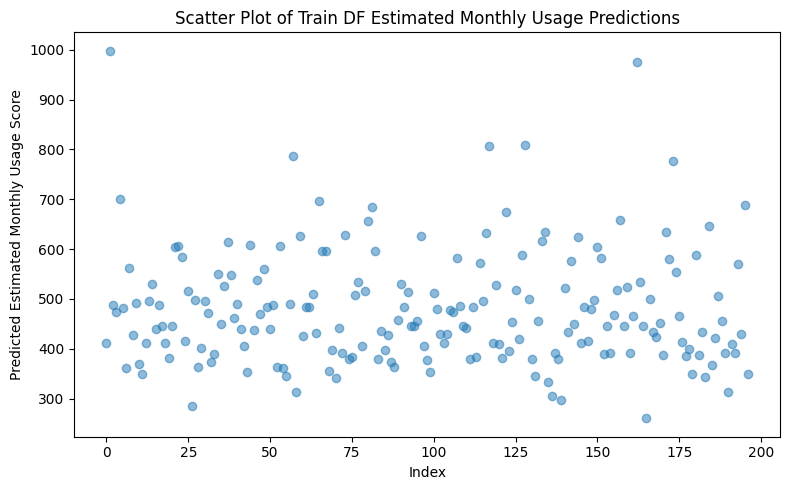

In [40]:
# Scatter Plot Function
def create_scatter_plot(ax, predictions, title):
    ax.scatter(range(len(predictions)), predictions, alpha=0.5)
    ax.set_xlabel("Index")
    ax.set_ylabel("Predicted Estimated Monthly Usage Score")
    ax.set_title(title)


# Plotting
fig, ax = plt.subplots(figsize=(8, 5))  # Single plot

# Plot for train set
create_scatter_plot(ax,train_df_predictions_original_scale,"Scatter Plot of Train DF Estimated Monthly Usage Predictions")

plt.tight_layout()
plt.show()

## Predict Is Active Member

### Prepare Dataset For Is Active Member Prediction

In [41]:
train_df_is_active_member = dataset.copy()

# Filter rows without NaN values in 'IsActiveMember'
train_df_is_active_member_not_nan = train_df_is_active_member.dropna(subset=['IsActiveMember'])


# Extract input features and target variable for rows without NaN
train_df_x = train_df_is_active_member_not_nan.drop("IsActiveMember", axis=1)
train_df_y = train_df_is_active_member_not_nan["IsActiveMember"]


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_df_x[numerical_columns] = scaler.fit_transform(train_df_x[numerical_columns])


# Convert scaled features and target variable to PyTorch tensors
train_x = torch.tensor(train_df_x.values).float()
train_y = torch.tensor(train_df_y.values).float().unsqueeze(1)
train_x.shape

torch.Size([3822, 18])

### Model Train For Predicting Is Active Member

In [42]:
train_loader, test_loader = data_split(train_x, train_y, 0.2, 32)

model = {
    "model name": "3-nh-tanh",
    "input_size": 18,
    "output_size": 1,
    "hidden_units": [64, 32, 64],
    "drop_out": 0.5,
    "batch_normalization": True,
    "activation": "tanh",
}


train_model = {
    "train method": "x.u-e.100-Adam-lr.0001-BCEWithLogits",
    "model": None,
    "train_loader": train_loader,
    "test_loader": test_loader,
    "numepochs": 100,
    "initialization_method": "xavier_uniform",
    "nonlinearity": 'tanh',
    "optimizer_type": "Adam",
    "learning_rate": 0.01,
    "scheduler_settings": ["min", 5, 2, 0.1],
    "lossfunc": "BCEWithLogits",
}

model_predict_is_active_member_train_df = []

test_model_1, model_train_df_is_active_member = test_multiple_model_categorical(model, train_model)
model_predict_is_active_member_train_df.append(test_model_1)

Learning rate at epoch  5 : 1.00e-03
Learning rate at epoch 13 : 1.00e-04
Learning rate at epoch 21 : 1.00e-05
Learning rate at epoch 29 : 1.00e-06
Learning rate at epoch 37 : 1.00e-07
Learning rate at epoch 45 : 1.00e-08


### Visualize Model Performance of Is Active Member Predictor

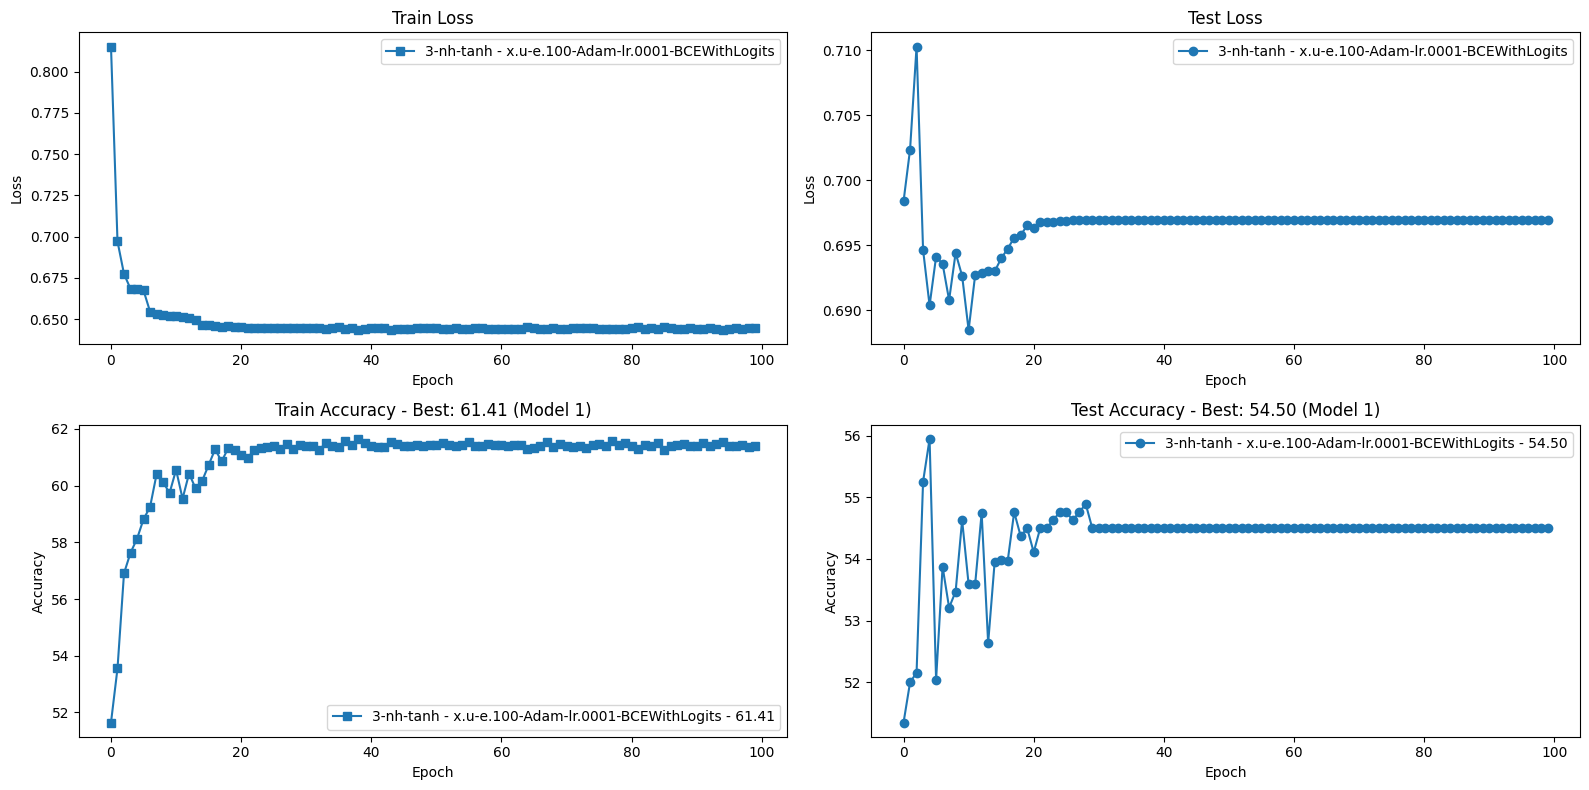

{'model name': '3-nh-tanh', 'train method': 'x.u-e.100-Adam-lr.0001-BCEWithLogits', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=18, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace=False)
    (batch_norm_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
), 'train_loader': {'Number of batches': 95, 'Batch size': 32, 'Total samples': 3040}, 'test_loader': {'N

In [43]:
plot_model_test_categorical(model_predict_is_active_member_train_df)

### Update Original Dataset NaN Values With Predicted Results

In [44]:
# Filter rows with NaN values in 'IsActiveMember'
train_df_nan_mask = train_df_is_active_member["IsActiveMember"].isna()
train_df_is_active_member_nan = train_df_is_active_member[train_df_nan_mask]


# Extract input features and target variable for rows with NaN
train_x = train_df_is_active_member_nan.drop("IsActiveMember", axis=1)


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
train_x[numerical_columns] = scaler.fit_transform(train_x[numerical_columns])

# Convert scaled features and target variable to PyTorch tensors
train_x = torch.tensor(train_x.values).float().to(device)

# Predict Train Df NaN values
model_train_df_is_active_member.eval()
with torch.no_grad():
    train_df_predictions = model_train_df_is_active_member(train_x).squeeze()


train_df_predictions_class = (train_df_predictions > 0).float().cpu().numpy()


# Replace NaN values with predictions in the original df
dataset.loc[train_df_nan_mask, "IsActiveMember"] = train_df_predictions_class

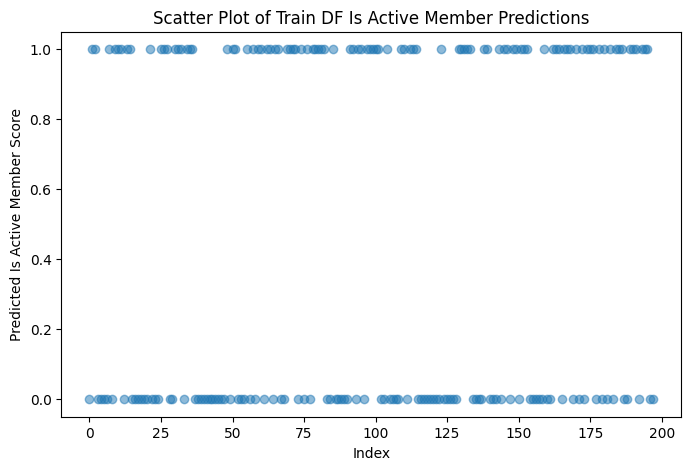

In [45]:
# Scatter Plot Function
def create_scatter_plot(ax, predictions, title):
    ax.scatter(range(len(predictions)), predictions, alpha=0.5)
    ax.set_xlabel("Index")
    ax.set_ylabel("Predicted Is Active Member Score")
    ax.set_title(title)


# Plotting
fig, ax = plt.subplots(figsize=(8, 5))  # Single plot

# Plot for train set
create_scatter_plot(
    ax,
    train_df_predictions_class,
    "Scatter Plot of Train DF Is Active Member Predictions",
)

# Data Cleaning

## Replace Outliners with Mean

In [46]:
# replace highest and lowest one percent with the column wise mean
def find_and_replace_outliers(df):
    replaced_outliers = {}
    df_clean = df.copy()
    columns = numerical_columns
    for column in columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            # Calculate the 1st and 99th percentiles
            lower_bound = df[column].quantile(0.01)
            upper_bound = df[column].quantile(0.99)

            # Replace outliers with column-wise mean
            outliers_lower = df[column] < lower_bound
            outliers_upper = df[column] > upper_bound
            outliers = outliers_lower | outliers_upper

            replaced_outliers[column] = outliers.sum()

            df_clean.loc[outliers, column] = df[column].mean()

    return replaced_outliers, df_clean.copy()

outliners, dataset = find_and_replace_outliers(dataset)
print(outliners)

{'NetworkScore': 77, 'Age': 0, 'Tenure': 0, 'MonthlyCharge': 82, 'EstimatedMonthlyUsage': 82}


## Clean Data Transform

In [47]:
dataset[numerical_columns].describe()

,NetworkScore,Age,Tenure,MonthlyCharge,EstimatedMonthlyUsage
count,4020.000000,4020.000000,4020.000000,4020.000000,4020.000000
mean,50.619994,43.878804,10.092786,109.803538,544.885596
std,27.557981,15.006456,6.076202,50.848261,245.679404
min,2.000000,18.000000,0.000000,21.890000,108.370000
25%,28.000000,31.000000,5.000000,66.025000,346.575000
50%,50.605657,44.000000,10.000000,109.808458,543.480000
75%,75.000000,56.000000,15.000000,153.867500,754.977500
max,99.000000,70.000000,20.000000,198.220000,990.220000


In [48]:
train = dataset.copy()

scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])

train.to_csv('clean_data.csv',index = False)
train.head()

,NetworkScore,Age,Tenure,MonthlyCharge,HasInternetService,IsActiveMember,EstimatedMonthlyUsage,Exited,Region_1,Region_2,Region_3,Region_4,Gender_1,Gender_2,Gender_3,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,-0.929792,-1.191556,0.149325,0.479849,0.0,1.0,-0.542375,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.630749,1.074418,1.136907,-1.653822,1.0,1.0,-0.046756,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.603167,-1.058263,-0.509063,0.417499,0.0,0.0,-0.145922,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.365291,1.407649,-1.332048,-0.895590,0.0,1.0,-1.214765,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.022501,1.074418,0.972310,-1.348169,1.0,1.0,1.454900,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Final Test

In [49]:
train_x = train.drop(['Exited'], axis=1) 
train_y = train['Exited'].values

x = torch.tensor(train_x.values).float()
y = torch.tensor(train_y).float().unsqueeze(1)

In [50]:
train_loader,test_loader = data_split(x,y,0.1,32)

model = {
    'model name' : '3-nh-tanh',
    'input_size': 18,
    'output_size': 1,
    'hidden_units': [64,32,16,32,64],
    'drop_out': 0.5,
    'batch_normalization': True,
    'activation': 'tanh'
}


train_model = {
    'train method' : 'x.u-e.100-Adam-lr.001-BCEWithLogits',
    'model' : None,
    'train_loader' : train_loader,
    'test_loader' : test_loader,
    'numepochs' : 100,
    'initialization_method' : 'xavier_uniform',
    'nonlinearity' : 'tanh',
    'optimizer_type' : 'Adam',
    'learning_rate' : 0.01,
    'scheduler_settings': ['min',5,2,0.1],
    'lossfunc' : 'BCEWithLogits'
}

model_test_1 = []

test_model_1,model = test_multiple_model_categorical(model,train_model)
model_test_1.append(test_model_1)

Learning rate at epoch  5 : 1.00e-03
Learning rate at epoch 13 : 1.00e-04
Learning rate at epoch 21 : 1.00e-05
Learning rate at epoch 29 : 1.00e-06
Learning rate at epoch 37 : 1.00e-07
Learning rate at epoch 45 : 1.00e-08


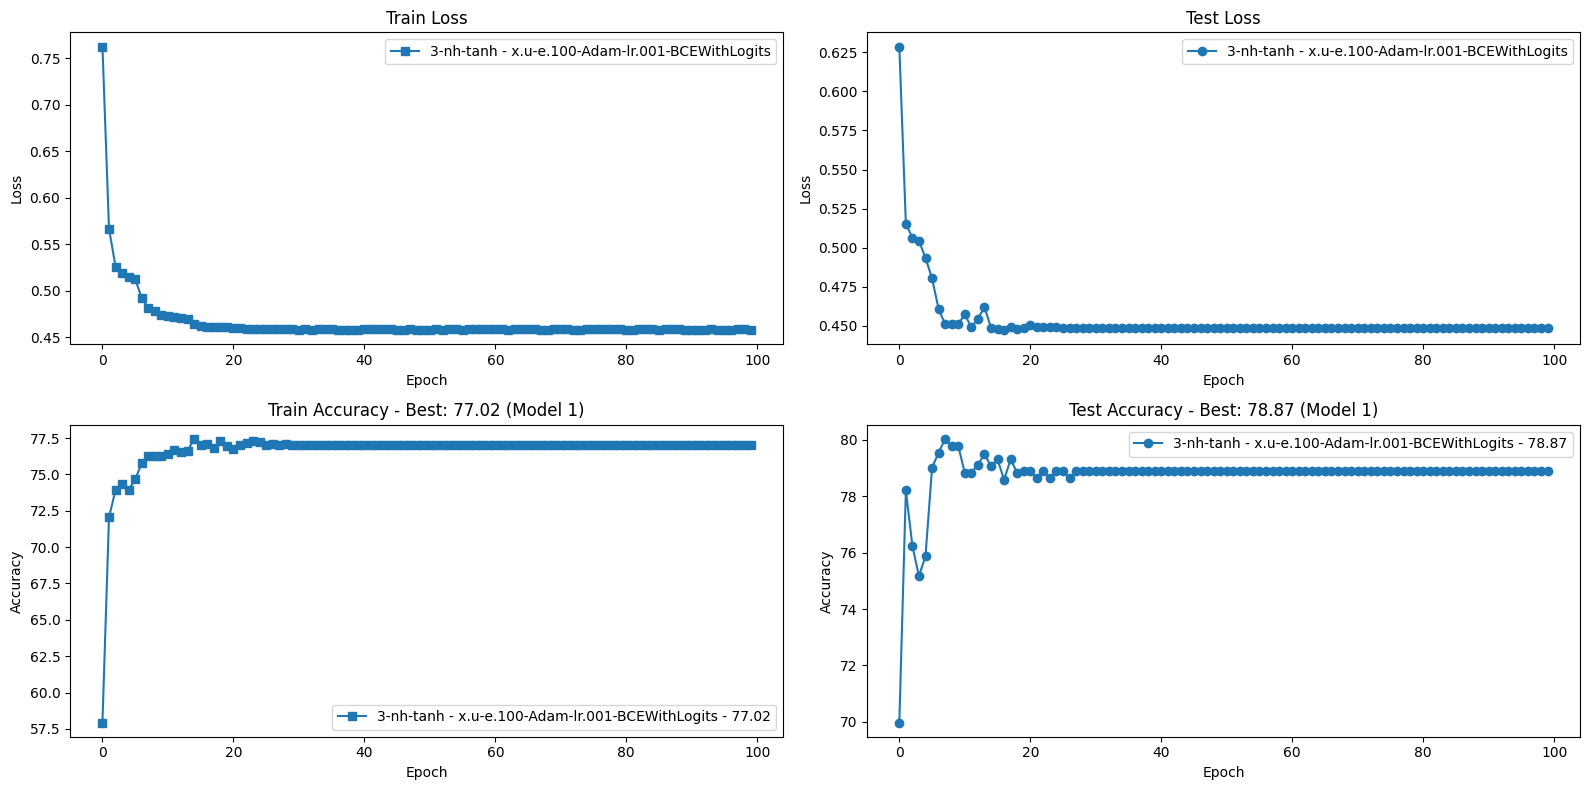

{'model name': '3-nh-tanh', 'train method': 'x.u-e.100-Adam-lr.001-BCEWithLogits', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=18, out_features=64, bias=True)
    (hidden1): Linear(in_features=64, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=16, bias=True)
    (hidden3): Linear(in_features=16, out_features=32, bias=True)
    (hidden4): Linear(in_features=32, out_features=64, bias=True)
    (hidden5): Linear(in_features=64, out_features=64, bias=True)
    (output): Linear(in_features=64, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace=False)
    (dropout_3): Dropout(p=0.5, inplace=False)
    (dropout_4): Dropout(p=0.5, inplace=False)
    (batch_norm_0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch_norm_1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_runn

In [51]:
plot_model_test_categorical(model_test_1)

# Demo

## Load Data

In [17]:
clean_data = pd.read_csv('clean_data.csv')

train_x = clean_data.drop(['Exited'], axis=1) 
train_y = clean_data['Exited'].values

x = torch.tensor(train_x.values).float()
y = torch.tensor(train_y).float().unsqueeze(1)

## Demo Test

In [18]:
train_loader,test_loader = data_split(x,y,0.1,2)

model = {
    'model name' : '5-nh-relu',
    'input_size': 18,
    'output_size': 1,
    'hidden_units': [16,32,64,128,256,512,1024,2048,4096],
    'drop_out': 0.5,
    'batch_normalization': True,
    'activation': 'relu'
}


train_model = {
    'train method' : 'x.u-e.100-Adam-lr.001-BCEWithLogits',
    'model' : None,
    'train_loader' : train_loader,
    'test_loader' : test_loader,
    'numepochs' : 100,
    'initialization_method' : 'kaiming_uniform',
    'nonlinearity' : 'relu',
    'optimizer_type' : 'Adam',
    'learning_rate' : 0.001,
    'scheduler_settings': ['min',10,5,0.1],
    'lossfunc' : 'BCEWithLogits'
}

model_test_1 = []

test_model_1,model = test_multiple_model_categorical(model,train_model)
model_test_1.append(test_model_1)

Learning rate at epoch 10 : 1.00e-04
Learning rate at epoch 26 : 1.00e-05
Learning rate at epoch 42 : 1.00e-06
Learning rate at epoch 58 : 1.00e-07
Learning rate at epoch 74 : 1.00e-08


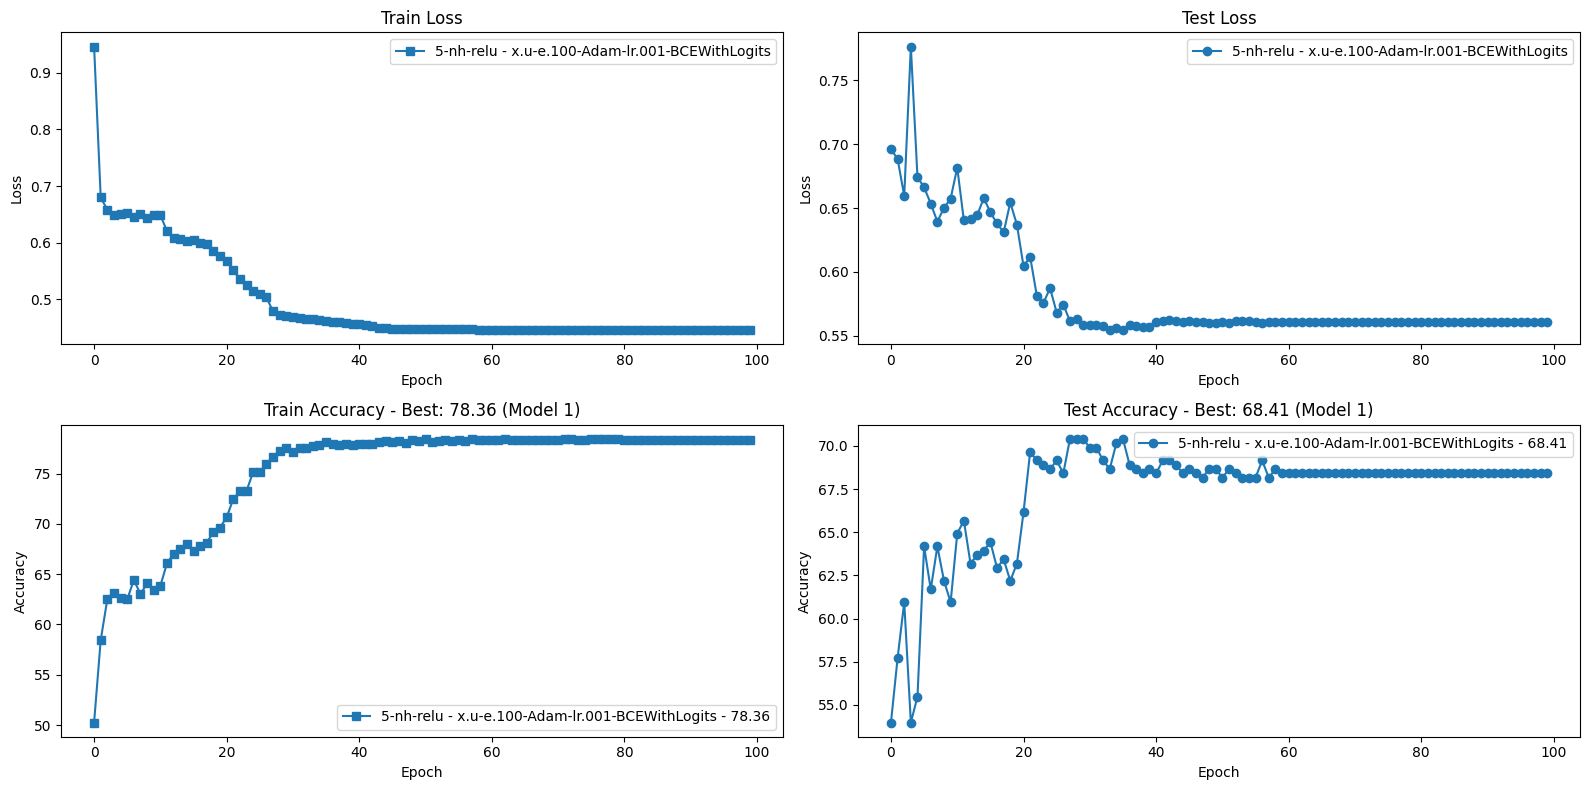

{'model name': '5-nh-relu', 'train method': 'x.u-e.100-Adam-lr.001-BCEWithLogits', 'model': Model(
  (layers): ModuleDict(
    (input): Linear(in_features=18, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=32, bias=True)
    (hidden2): Linear(in_features=32, out_features=64, bias=True)
    (hidden3): Linear(in_features=64, out_features=128, bias=True)
    (hidden4): Linear(in_features=128, out_features=256, bias=True)
    (hidden5): Linear(in_features=256, out_features=512, bias=True)
    (hidden6): Linear(in_features=512, out_features=1024, bias=True)
    (hidden7): Linear(in_features=1024, out_features=2048, bias=True)
    (hidden8): Linear(in_features=2048, out_features=4096, bias=True)
    (hidden9): Linear(in_features=4096, out_features=4096, bias=True)
    (output): Linear(in_features=4096, out_features=1, bias=True)
    (dropout_0): Dropout(p=0.5, inplace=False)
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.5, inplace

In [19]:
plot_model_test_categorical(model_test_1)